# Project Title

## Overview

A one-paragraph overview of the project, including the business problem, data, methods, results and recommendations.

## Business Problem

Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective?
- What exactly is your deliverable: your analysis, or the model itself?
- Does your business understanding/stakeholder require a specific type of model?
    - For example: a highly regulated industry would require a very transparent/simple/interpretable model, whereas a situation where the model itself is your deliverable would likely benefit from a more complex and thus stronger model
   

Additional questions to consider for classification:

- What does a false positive look like in this context?
- What does a false negative look like in this context?
- Which is worse for your stakeholder?
- What metric are you focusing on optimizing, given the answers to the above questions?

## Data Understanding

Describe the data being used for this project.

Questions to consider:

- Where did the data come from, and how do they relate to the data analysis questions?
- What do the data represent? Who is in the sample and what variables are included?
- What is the target variable?
- What are the properties of the variables you intend to use?

In [34]:
# SKLearn imports

# Processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold

# Scoring
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Utility import
from util import evaluate_model

In [4]:
# Update Pandas settings for printing dataframes

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [5]:
df_birds = pd.read_csv('../../data/birds_withrange.csv', low_memory=False)

In [6]:
# Drop duplicate name and scientific name columns
df_birds.drop(columns=['English name_x', 'English name_y', 'Scientific Name'], axis=1, inplace=True)

df_birds.head()

,SpecID,PassNonPass,IOCOrder,BLFamilyLatin,BLFamilyEnglish,BLFamSequID,Taxo,Scientific,English,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,Diet-5Cat,Diet-Source,Diet-Certainty,Diet-EnteredBy,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-Source,ForStrat-SpecLevel,ForStrat-EnteredBy,Nocturnal,BodyMass-Value,BodyMass-Source,BodyMass-SpecLevel,BodyMass-Comment,Record-Comment,Family,Global IUCN Red List Category,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland,breeding_range
0,37.00,Nonpasseriformes,Rheiformes,Rheidae,Rheas,3.00,BL3,Rhea americana,Greater Rhea,20.00,10.00,10.00,0.00,0.00,0.00,20.00,0.00,20.00,20.00,Omnivore,Ref_1,A,Jennifer,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,23000.00,Dunning08,1.00,NaN,NaN,Rheidae (Rheas),NT,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,SA
1,38.00,Nonpasseriformes,Rheiformes,Rheidae,Rheas,3.00,BL3,Rhea pennata,Lesser Rhea,20.00,0.00,0.00,0.00,10.00,0.00,0.00,0.00,30.00,40.00,PlantSeed,Ref_1,A,Jennifer,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,23900.00,Dunning08,1.00,NaN,NaN,Rheidae (Rheas),LC,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,SA
2,45.00,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.00,BL3,Casuarius casuarius,Southern Cassowary,10.00,0.00,0.00,0.00,10.00,0.00,80.00,0.00,0.00,0.00,FruiNect,Ref_1,A,Jennifer,0.00,0.00,80.00,20.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,44000.00,Dunning08,1.00,NaN,NaN,"Casuariidae (Cassowaries, Emus)",LC,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,AU
3,46.00,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.00,BL3,Casuarius bennetti,Dwarf Cassowary,10.00,0.00,0.00,0.00,10.00,0.00,80.00,0.00,0.00,0.00,FruiNect,Ref_1,B,Jennifer,0.00,0.00,80.00,20.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,34999.99,Dunning08,1.00,NaN,NaN,"Casuariidae (Cassowaries, Emus)",LC,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,AU
4,47.00,Nonpasseriformes,Casuariiformes,Casuariidae,Cassowaries,4.00,BL3,Casuarius unappendiculatus,Northern Cassowary,20.00,0.00,0.00,0.00,10.00,0.00,60.00,0.00,0.00,10.00,FruiNect,Ref_1,A,Jennifer,0.00,0.00,80.00,20.00,0.00,0.00,0.00,0.00,Ref_1,1.00,Jessica,0.00,46073.85,Dunning08,1.00,NaN,NaN,"Casuariidae (Cassowaries, Emus)",LC,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,AU


In [7]:
# This is the column that is throwing the mixed type error when reading in. 
# We won't be using it anyway so it's fine.

df_birds.columns.get_loc('Record-Comment')

39

In [8]:
df_birds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9597 entries, 0 to 9596
Data columns (total 84 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   SpecID                         9597 non-null   float64
 1   PassNonPass                    9597 non-null   object 
 2   IOCOrder                       9597 non-null   object 
 3   BLFamilyLatin                  9597 non-null   object 
 4   BLFamilyEnglish                9597 non-null   object 
 5   BLFamSequID                    9597 non-null   float64
 6   Taxo                           9597 non-null   object 
 7   Scientific                     9597 non-null   object 
 8   English                        9597 non-null   object 
 9   Diet-Inv                       9597 non-null   float64
 10  Diet-Vend                      9597 non-null   float64
 11  Diet-Vect                      9597 non-null   float64
 12  Diet-Vfish                     9597 non-null   f

In [9]:
df_birds.describe()

,SpecID,BLFamSequID,Diet-Inv,Diet-Vend,Diet-Vect,Diet-Vfish,Diet-Vunk,Diet-Scav,Diet-Fruit,Diet-Nect,Diet-Seed,Diet-PlantO,ForStrat-watbelowsurf,ForStrat-wataroundsurf,ForStrat-ground,ForStrat-understory,ForStrat-midhigh,ForStrat-canopy,ForStrat-aerial,PelagicSpecialist,ForStrat-SpecLevel,Nocturnal,BodyMass-Value,BodyMass-SpecLevel,endemic_breeding,migratory,africa,antarctica,asia,australasia,caribbean,central_amer,central_asia,europe,high_seas,mid_east,north_amer,oceania,south_amer,agriculture_threat,biological_threat,climate_change_threat,energy_mining_threat,geological_threat,human_intrusions_threat,natural_systems_threat,pollution_threat,res_comm_dev_threat,transportation_threat,invasive_threat,artificial_aquatic,artificial_terrestrial,caves_subterranean,desert,forest,grassland,introduced_vegetation,marine_coastal_supratidal,marine_intertidal,marine_neritic,marine_oceanic,rocky_areas,savanna,shrubland,wetlands_inland
count,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00,9597.00
mean,7344.09,113.09,55.71,2.57,2.15,2.72,0.36,0.60,15.03,5.85,10.69,4.33,2.54,4.48,31.72,23.60,23.53,12.08,2.03,0.03,0.97,0.03,273.31,0.92,0.26,0.18,0.23,0.01,0.31,0.13,0.08,0.12,0.06,0.05,0.00,0.06,0.13,0.03,0.33,0.20,0.21,0.11,0.05,0.00,0.03,0.08,0.05,0.06,0.04,0.09,0.03,0.35,0.00,0.02,0.57,0.16,0.00,0.04,0.04,0.04,0.02,0.04,0.15,0.30,0.16
std,4654.52,54.64,37.12,12.07,7.67,12.43,3.80,5.44,25.63,19.21,21.77,13.23,14.13,17.00,37.81,25.83,26.19,21.62,10.78,0.17,0.18,0.18,1643.51,0.28,0.44,0.39,0.42,0.10,0.46,0.34,0.27,0.32,0.23,0.23,0.06,0.24,0.33,0.18,0.47,0.40,0.41,0.32,0.21,0.07,0.18,0.27,0.21,0.24,0.19,0.29,0.17,0.48,0.06,0.13,0.50,0.37,0.02,0.19,0.19,0.20,0.13,0.19,0.35,0.46,0.37
min,28.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3434.00,68.00,20.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,15.16,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,6961.00,109.00,60.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.00,20.00,20.00,0.00,0.00,0.00,1.00,0.00,36.23,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,10829.00,163.00,100.00,0.00,0.00,0.00,0.00,0.00,20.00,0.00,10.00,0.00,0.00,0.00,60.00,40.00,40.00,20.00,0.00,0.00,1.00,0.00,127.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
max,20107.00,194.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,1.00,1.00,1.00,111000.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [10]:
diet_cols = ['Diet-Inv', 'Diet-Vend', 'Diet-Vect', 'Diet-Vfish', 'Diet-Vunk', 'Diet-Scav', 'Diet-Fruit',
             'Diet-Nect', 'Diet-Seed', 'Diet-PlantO']

In [11]:
df_birds.isnull().sum()

SpecID                0
PassNonPass           0
IOCOrder              0
BLFamilyLatin         0
BLFamilyEnglish       0
                   ... 
rocky_areas           0
savanna               0
shrubland             0
wetlands_inland       0
breeding_range     2703
Length: 84, dtype: int64

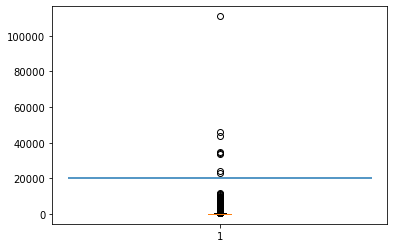

In [12]:
# Plot body weight
# Notes: appears to be a few outliers here above 20,000 grams

plt.boxplot(df_birds['BodyMass-Value']);
plt.hlines(20000, xmin=0, xmax=2);

In [13]:
# Googled each of these and the weights are actually reasonable. The biggest 'outlier' is an ostrich.
# Excluding these from final analysis on the basis that these are large, flightless birds.
# Also, none of them are 

weight_outliers = df_birds[df_birds['BodyMass-Value'] > 20000][['English', 'BodyMass-Value', 'Global IUCN Red List Category']]

weight_outliers

,English,BodyMass-Value,Global IUCN Red List Category
0,Greater Rhea,23000.00,NT
1,Lesser Rhea,23900.00,LC
2,Southern Cassowary,44000.00,LC
3,Dwarf Cassowary,34999.99,LC
4,Northern Cassowary,46073.85,LC
3240,Emperor Penguin,33569.33,NT
8509,Ostrich,111000.00,LC
8510,Emu,34093.25,LC


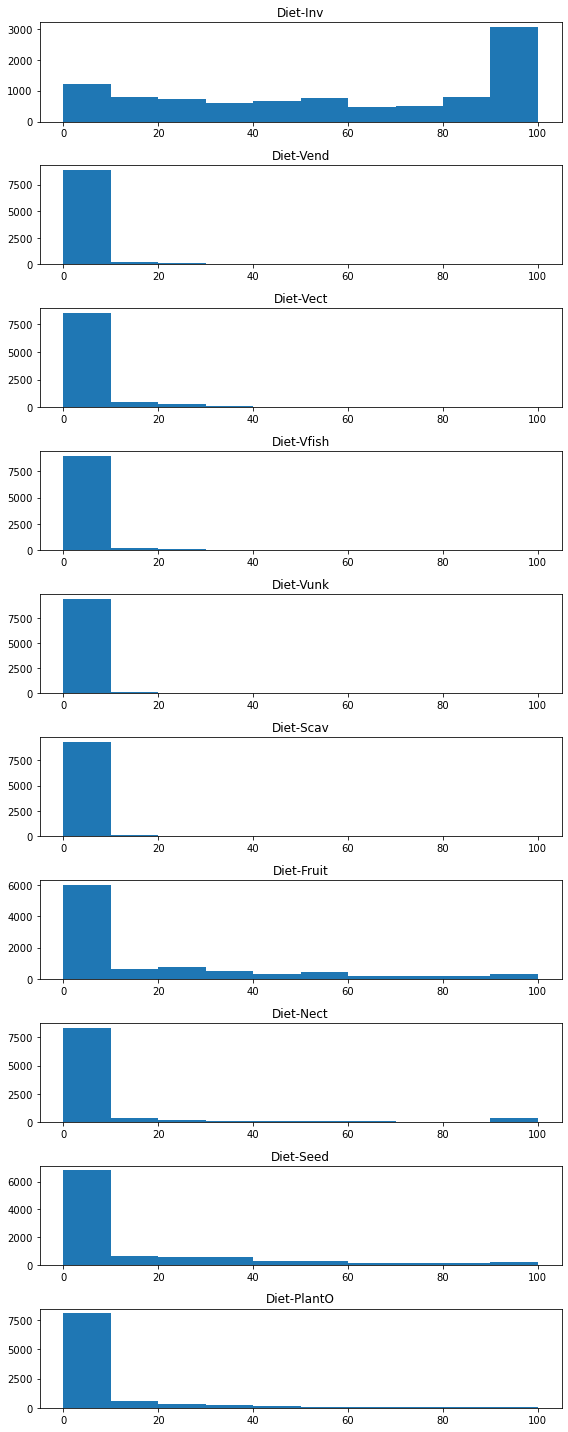

In [14]:
# Check distribution of diet cols
# Comments: None of them appear to have a normal distribution. Will need some transformation if doing 
# a linear model. Log is not suitable because there are 0s so may need to use a standard scalar

diet_cols = ['Diet-Inv', 'Diet-Vend', 'Diet-Vect', 'Diet-Vfish', 'Diet-Vunk', 'Diet-Scav', 'Diet-Fruit',
             'Diet-Nect', 'Diet-Seed', 'Diet-PlantO']

fig, ax = plt.subplots(nrows=len(diet_cols), figsize=(8,20))

for i, col in enumerate(diet_cols):
    ax[i].hist(df_birds[col])
    ax[i].set_title(col);

plt.tight_layout();

In [15]:
# Saving min max scalar code 

# minMax = MinMaxScaler()

# diet_cols_tf = minMax.fit_transform(df_birds[diet_cols])

# diet_cols_tf = pd.DataFrame(diet_cols_tf, columns=df_birds[diet_cols].columns)

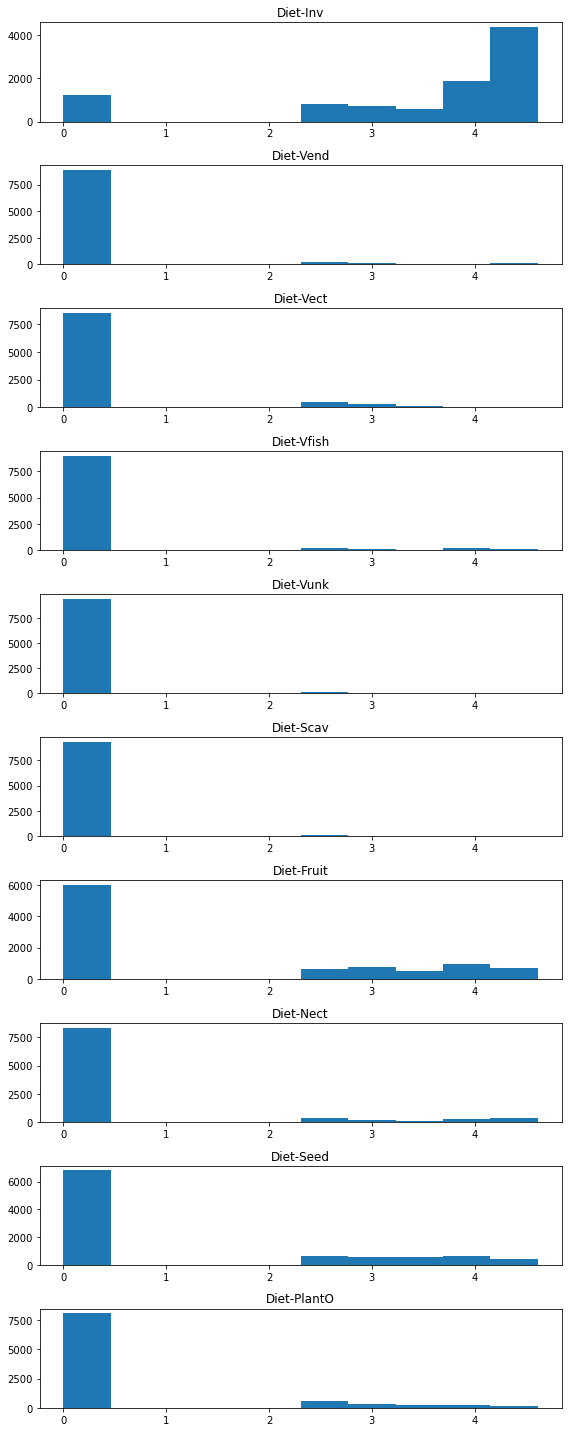

In [16]:
# Test log transforming. Note we need to add one because substantial number of 0s in the dataset
# Doesn't actually do all that much. May need to use a model that doesn't handle non-normality as well

fig, ax = plt.subplots(nrows=len(diet_cols), figsize=(8,20))

for i, col in enumerate(diet_cols):
    ax[i].hist(np.log(df_birds[col] + 1))
    ax[i].set_title(col);

plt.tight_layout();

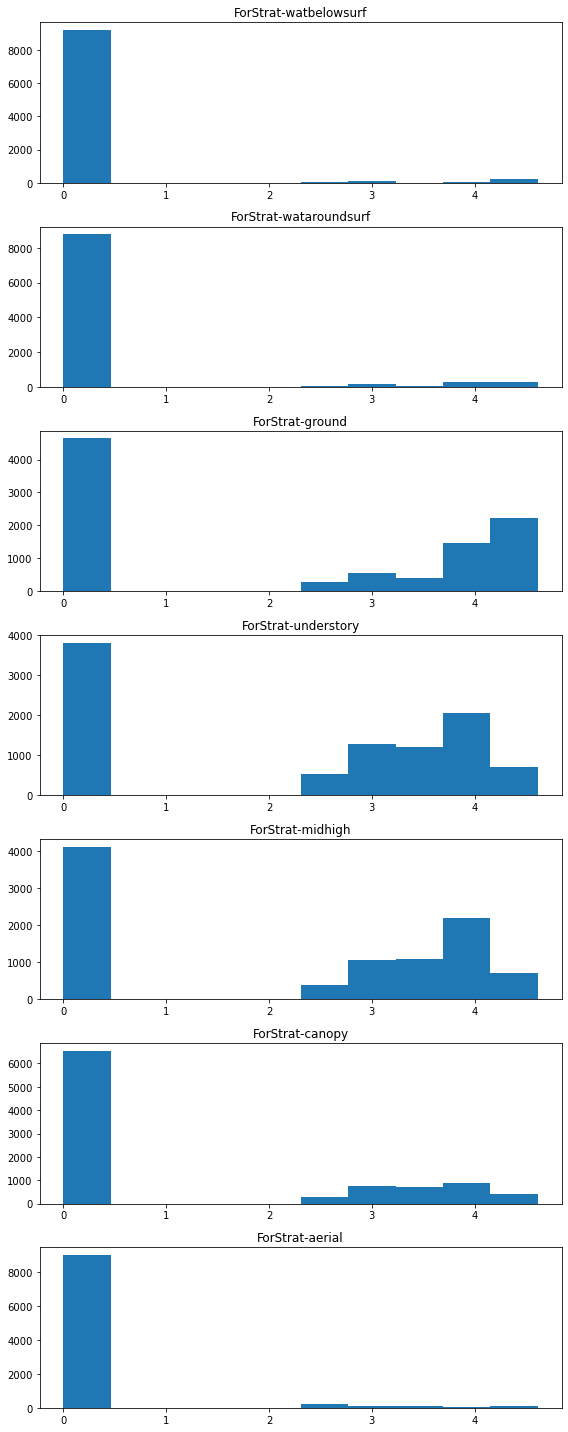

In [17]:
foraging_cols = ['ForStrat-watbelowsurf', 'ForStrat-wataroundsurf', 'ForStrat-ground', 'ForStrat-understory',
                'ForStrat-midhigh', 'ForStrat-canopy', 'ForStrat-aerial']

fig, ax = plt.subplots(nrows=len(foraging_cols), figsize=(8,20))

for i, col in enumerate(foraging_cols):
    ax[i].hist(np.log(df_birds[col] + 1))
    ax[i].set_title(col);

plt.tight_layout();

## Data Preparation

Describe and justify the process for preparing the data for analysis.

Questions to consider:

- Were there variables you dropped or created?
- How did you address missing values or outliers?
- Why are these choices appropriate given the data and the business problem?
- Can you pipeline your preparation steps to use them consistently in the modeling process?

In [18]:
# Remove outliers: all birds with a weight over 20K grams
weight_threshold = 20000
df_clean = df_birds.copy()

df_clean = df_clean[df_clean['BodyMass-Value'] < weight_threshold]

In [19]:
# Create the target variable

df_clean['threatened'] = 0

df_clean.loc[(df_clean['Global IUCN Red List Category'] == 'VU') |
             (df_clean['Global IUCN Red List Category'] == 'EN') |
             (df_clean['Global IUCN Red List Category'] == 'CR') |
             (df_clean['Global IUCN Red List Category'] == 'CR(PE)'), 'threatened'] = 1

In [20]:
# One hot encode Passerine and Diet 5 Category

to_encode = df_clean[['PassNonPass', 'Diet-5Cat']]

ohe = OneHotEncoder(drop='first', categories='auto', sparse=False)

cat_transformed = ohe.fit_transform(to_encode)

df_ohe = pd.DataFrame(cat_transformed, columns=ohe.get_feature_names(), index=df_clean.index)

In [21]:
# Create X and Y variables

to_remove = ['SpecID', 'PassNonPass', 'IOCOrder', 'BLFamilyLatin', 'BLFamilyEnglish', 'BLFamSequID', 'Taxo',
            'Scientific', 'English', 'Diet-5Cat', 'Diet-Source', 'Diet-Certainty', 'Diet-EnteredBy', 
            'BodyMass-Source', 'BodyMass-SpecLevel', 'BodyMass-Comment', 'Record-Comment', 'Family',
            'Global IUCN Red List Category', 'breeding_range', 'threatened', 'ForStrat-Source', 'ForStrat-EnteredBy']

X = df_clean.drop(columns=to_remove, axis=1)
X = pd.concat([X, df_ohe], axis=1)

y = df_clean['threatened']

In [22]:
# Perform test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

### Pipeline Set Up:

- We have no nulls to take care of
- Different strategies for numerical vs. categorical:
    - Numerics: if decision tree then nothing.
    - Categoricals:
        - Binary:
        - Nominal:
        - Ordinal: None

## Modeling

Describe and justify the process for analyzing or modeling the data.

Questions to consider:

- How will you analyze the data to arrive at an initial approach?
- How will you iterate on your initial approach to make it better?
- What model type is most appropriate, given the data and the business problem?

### Dummy model

- Running below to have a baseline to compare against
- Metrics based on selecting most common outcome

Accuracy: 0.8708
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/Users/jeffreymarvel/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


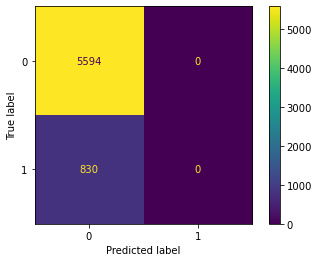

In [37]:
dc = DummyClassifier(random_state=42, strategy='most_frequent')

dc.fit(X_train, y_train)

acc, prec, rec, f1 = evaluate_model(dc, X_train, y_train, plot_cf=True)

### First simple model

- First simple logistic regression without any hyperparameter tuning or scaling
- Requires 4,000 steps to converge. Performs reasonably similarly across Train and Test
- Has only improve accuracy by 2-3 ppt


In [35]:
# First logistic regression

simple_log = LogisticRegression(max_iter=4000, random_state=42)

simple_log.fit(X_train, y_train)

LogisticRegression(max_iter=4000, random_state=42)

Train results
Accuracy: 0.9159
Precision: 0.6981
Recall: 0.6157
F1 Score: 0.6543

Test results
Accuracy: 0.8989
Precision: 0.6226
Recall: 0.5526
F1 Score: 0.5855



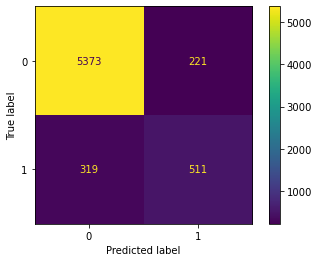

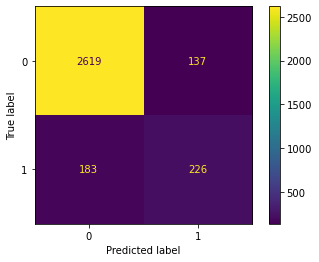

In [36]:
for i, item in enumerate([(X_train, y_train), (X_test, y_test)]):
    if i == 0:
        print("Train results")
    else:
        print("Test results")
        
    acc, prec, rec, f1 = evaluate_model(simple_log, item[0], item[1], plot_cf=True)
    print('')

## Evaluation

The evaluation of each model should accompany the creation of each model, and you should be sure to evaluate your models consistently.

Evaluate how well your work solves the stated business problem. 

Questions to consider:

- How do you interpret the results?
- How well does your model fit your data? How much better is this than your baseline model? Is it over or under fit?
- How well does your model/data fit any relevant modeling assumptions?

For the final model, you might also consider:

- How confident are you that your results would generalize beyond the data you have?
- How confident are you that this model would benefit the business if put into use?
- What does this final model tell you about the relationship between your inputs and outputs?

### Baseline Understanding

- What does a baseline, model-less prediction look like?

In [26]:
# code here to arrive at a baseline prediction

### First $&(@# Model

Before going too far down the data preparation rabbit hole, be sure to check your work against a first 'substandard' model! What is the easiest way for you to find out how hard your problem is?

In [27]:
# code here for your first 'substandard' model

In [28]:
# code here to evaluate your first 'substandard' model

### Modeling Iterations

Now you can start to use the results of your first model to iterate - there are many options!

In [29]:
# code here to iteratively improve your models

In [30]:
# code here to evaluate your iterations

### 'Final' Model

In the end, you'll arrive at a 'final' model - aka the one you'll use to make your recommendations/conclusions. This likely blends any group work. It might not be the one with the highest scores, but instead might be considered 'final' or 'best' for other reasons.

In [31]:
# code here to show your final model

In [32]:
# code here to evaluate your final model

## Conclusions

Provide your conclusions about the work you've done, including any limitations or next steps.

Questions to consider:

- What would you recommend the business do as a result of this work?
- How could the stakeholder use your model effectively?
- What are some reasons why your analysis might not fully solve the business problem?
- What else could you do in the future to improve this project (future work)?
